In [2]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

In [3]:
pTrainData = 'train_grid.h5'
pTrainInput = 'train_input_'

**TODO** visualize streamlines of specific anatomic regions such as corpus callosum

In [4]:
from dipy.tracking.local import LocalTracking
from dipy.viz import window, actor
from dipy.viz.colormap import line_colors
from dipy.tracking.streamline import Streamlines
from dipy.tracking import metrics


def visSphere(sphere):
    '''
    Visualize sphere
    '''
    ren = window.Renderer()
    ren.SetBackground(1, 1, 1)
    ren.add(actor.point(sphere.vertices, window.colors.red, point_radius=0.05))
    window.show(ren)

def visStreamlines(streamlines, volume, vol_slice_idx = 40):
    '''
    Visualize streamline using vtk
    '''
    # Prepare the display objects.
    color = line_colors(streamlines)

    if window.have_vtk:
        vol_actor = actor.slicer(volume)

        vol_actor.display(x=vol_slice_idx)
        vol_actor2 = vol_actor.copy()
        vol_actor2.display(z=35)
        
        streamlines_actor = actor.line(streamlines, line_colors(streamlines))

        # Create the 3D display.
        r = window.Renderer()
        r.add(streamlines_actor)
        r.add(vol_actor)
        window.record(r, n_frames=1, out_path='deterministic.png', size=(800, 800))
        window.show(r)
    else:
        print('we need VTK for proper visualisation of our fibres.')
        
def filterStreamlinesByLength(streamlines, minimumLength = 80):
    '''
    Removes streamlines that are shorter (in mm) than minimumLength
    '''
    return [x for x in streamlines if metrics.length(x) > minimumLength]

# Data Handling

load bvec/bval and compute gradient table

In [5]:
bvals, bvecs = read_bvals_bvecs('100307/bvals', '100307/bvecs')
gtab = gradient_table(bvals=bvals, bvecs=bvecs,b0_threshold=5)

In [6]:
gtab.info

B-values shape (288,)
         min 5.000000 
         max 3010.000000 
B-vectors shape (288, 3)
         min -0.999389 
         max 0.999012 


In [7]:
np.min(gtab.bvals)

5.0

In [8]:
img = nb.load('100307/data.nii.gz')
dwi = img.get_data()

validate isotropic voxel size

In [9]:
img.header.get_zooms()[:3]

(1.25, 1.25, 1.25)

In [10]:
dwi.shape

(145, 174, 145, 288)

load binary brain segmentation

In [11]:
binarymask, options = nrrd.read('100307/nodif_brain_mask.nrrd')

visualize DWI data

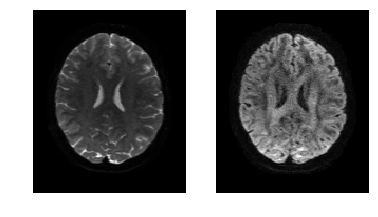

In [12]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Brain Tissue Segmentation
**TODO**: check if datasets are registered

**TODO**: not working right yet

Segmentation of T1w data wrt. tissue state (cortico spinal fluid, gray- & white matter)

In [12]:
img = nb.load('100307/T1w_acpc_dc_restore_1.25.nii.gz')
t1 = img.get_data()

In [ ]:
from dipy.segment.tissue import TissueClassifierHMRF
nclass = 3
beta = 0.1 # smoothness regularizer
hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(t1, nclass, beta)

Visualize segmentation results

In [ ]:
fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(PVE[..., 89, 0])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('CSF')
a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(PVE[:, :, 89, 1])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Gray Matter')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(PVE[:, :, 89, 2])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('White Matter')
plt.savefig('probabilities.png', bbox_inches='tight', pad_inches=0)
plt.show()

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [ ]:
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
ccmask = np.zeros(binarymask.shape)
ccmask[20:50,55:85,38:39] = 1

In [ ]:
ccseeds = seeds_from_mask(ccmask)

## Diffusion Tensor Imaging

compute fractional anisotropy and select seeds_count seeds per voxel with FA > 0.3

In [ ]:
import dipy.reconst.dti as dti
dti_wls = dti.TensorModel(gtab)
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
fit_wls = dti_wls.fit(dwi)

generate seeds at each voxel for tracking

In [ ]:
FA = fit_wls.fa
seeds = random_seeds_from_mask(FA > 0.5, seeds_count=1)

In [ ]:
seeds.shape

In [ ]:
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_wls,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)
runtime = time.time() - start_time

In [ ]:
GFA = dtipeaks.gfa
print('Runtime ' + str(runtime) + 's / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)

In [ ]:
visStreamlines(streamlines,t1w)

In [ ]:
streamlines_filtered = filterStreamlinesByLength(streamlines, 100)

In [41]:
visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

c:\users\user\anaconda3\envs\dti\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


# Streamline playground

In [ ]:
from dipy.tracking.streamline import values_from_volume
#from dipy.tracking.utils import length
import dipy.align.vector_fields as vfu

In [ ]:
d = values_from_volume(t1,streamlines_filtered)

In [ ]:
sfa = np.asarray(streamlines_filtered)

In [ ]:
sfa[0][0:2,:]

In [ ]:
dwi[23,95,47,2]

In [ ]:
sfa[0][0:5,:]
vfu.interpolate_scalar_3d(dwi[:,:,:,0],sfa[0][0:2,:])

In [ ]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

## Q-ball Reconstruction

In [ ]:
csamodel = CsaOdfModel(gtab, 4)

In [ ]:
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
GFA.shape

tracking

In [ ]:
classifier = ThresholdTissueClassifier(csapeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)

In [ ]:
len(seeds)

In [ ]:
streamlines_filtered = filterStreamlinesByLength(streamlines, 50)

In [ ]:
len(streamlines_filtered)

Visualisation

In [ ]:
visStreamlines(streamlines,t1)

## Constrained Spherical Deconvolution

In [ ]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.5)
print(response)
print(ratio)

In [ ]:
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [ ]:
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)
GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
classifier = ThresholdTissueClassifier(csd_peaks.gfa, .25)
streamlines_generator = LocalTracking(csd_peaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)

In [ ]:
visStreamlines(streamlines,t1)

## Anatomically curated white matter atlas

**TODO** load atlas ORG-800FC-100HCP 

**TODO** apply atlas based tractography approach of Lauren

# Evaluate streamlines

In [13]:
from dipy.tracking.utils import length # compute length of each streamline in mm

metrics: average lengths, touches gray matter, ...

# Generate Training data

store intermediate data

In [ ]:
streamlines_filtered, streamlines, seeds

In [ ]:
np.asarray(streamlines_filtered).shape

In [ ]:
np.save(pTrainInput + "_sl_filt.npy",streamlines_filtered)
np.save(pTrainInput + "_sl.npy",streamlines)
np.save(pTrainInput + "_seeds.npy",seeds)

load

In [14]:
streamlines_filtered = np.load(pTrainInput + "_sl_filt.npy")

In [16]:
streamlines_filtered = np.asarray(streamlines_filtered)

In [15]:
np.random.shuffle(streamlines_filtered)

dataset: (current Position, last direction, local DWI data) -> new direction

**TODO** generate synthetic training data

** 1st simple training data generator **

This function generates training data given segmented streamlines and a dwi dataset. The DWI data of a spheroidal region D_{N_{p_i}} next to the current streamline position p_i will be used to predict p_{i+1}. 

**TODO** reshape X such that it reflects the spatial orientation of our data

**TODO** Parallelize + optimize data generator

## SPHERE

In [ ]:
from dipy.tracking.streamline import values_from_volume
import dipy.align.vector_fields as vfu
from dipy.core.sphere import Sphere
from dipy.core import subdivide_octahedron 

def generateSimpleTraindataFromStreamlines(streamlines, dwi, rec_level_sphere = 3):
    '''
    
    '''
    sfa = np.asarray(streamlines)
    sph = subdivide_octahedron.create_unit_sphere(recursion_level=rec_level_sphere) # create unit sphere with 4 ** recursion_level + 2 vertices
    #visSphere(sph)
    dx,dy,dz,dw = dwi.shape
    noStreamlines = min(len(sfa), 1000) # FIXME: spares us some time right now
    train_X = []
    train_Y = []
    
    for streamlineIndex in range(0,noStreamlines):
        print('Streamline ' + str(streamlineIndex) + '/' + str(noStreamlines))
        lengthStreamline = len(sfa[streamlineIndex])
        for streamlineElementIndex in range(0,lengthStreamline-1):
            # center sphere around current streamline position
            sph2 = sph.vertices + sfa[streamlineIndex][streamlineElementIndex]
            sph2 = np.vstack((sph2,sfa[streamlineIndex][streamlineElementIndex]))
            
            # interpolate data given these coordinates for each channel
            x = np.zeros([4**rec_level_sphere+2+1,dw])
            for i in range(0,dw):
                x[:,i] = vfu.interpolate_scalar_3d(dwi[:,:,:,i],sph2)[0]
            train_X.append(x)
            
            old_y = sfa[streamlineIndex][streamlineElementIndex+1]
            nextStreamlineDirection = sfa[streamlineIndex][streamlineElementIndex] - sfa[streamlineIndex][streamlineElementIndex+1]
            
            train_Y.append(nextStreamlineDirection) # dont store absolute value but relative displacement
    train_X = np.asarray(train_X)
    train_Y = np.asarray(train_Y)
    return train_X, train_Y

In [ ]:
start_time = time.time()
train_X, train_Y = generateSimpleTraindataFromStreamlines(streamlines_filtered, dwi)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
train_X.shape

In [ ]:
train_Y.shape

## 3D GRID

In [126]:
from dipy.tracking.streamline import values_from_volume
import dipy.align.vector_fields as vfu
from dipy.core.sphere import Sphere
from dipy.core import subdivide_octahedron 

def generateGridSimpleTraindataFromStreamlines(streamlines, dwi, rec_level_sphere = 3, noX=3, noY=3,noZ=3,coordinateScaling = 1):
    '''
    
    '''
    sfa = np.asarray(streamlines)
    dx,dy,dz,dw = dwi.shape
    noStreamlines = min(len(sfa), 1000) # FIXME: spares us some time right now
    train_X = []
    train_Y = []
    
    for streamlineIndex in range(0,noStreamlines):
        if((streamlineIndex % 100) == 0):
            print('Streamline ' + str(streamlineIndex) + '/' + str(noStreamlines))
        lengthStreamline = int(len(sfa[streamlineIndex]) / 10)
        for streamlineElementIndex in range(0,lengthStreamline-1):           
            x_ = coordinateScaling * np.linspace(-1., 1., noX)
            y_ = coordinateScaling * np.linspace(-1., 1., noY)
            z_ = coordinateScaling * np.linspace(-1., 1., noZ)
            coordVecs = np.vstack(np.meshgrid(x_,y_,z_)).reshape(3,-1).T + sfa[streamlineIndex][streamlineElementIndex]
            
            # interpolate data given these coordinates for each channel
            x = np.zeros([noX,noY,noZ,dw])
            for i in range(0,dw):
                x[:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(dwi[:,:,:,i],coordVecs)[0], [noX,noY,noZ])
            train_X.append(x)
            old_y = sfa[streamlineIndex][streamlineElementIndex+1]
            nextStreamlineDirection = sfa[streamlineIndex][streamlineElementIndex] - sfa[streamlineIndex][streamlineElementIndex+1]
            
            train_Y.append(nextStreamlineDirection) # dont store absolute value but relative displacement
    train_X = np.asarray(train_X)
    train_Y = np.asarray(train_Y)
    return train_X, train_Y

In [127]:
start_time = time.time()
train_X_16_16_16, train_Y_16_16_16 = generateGridSimpleTraindataFromStreamlines(streamlines_filtered, dwi, noX=8,noY=8,noZ=8,coordinateScaling=0.5)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Streamline 0/1000
Streamline 100/1000
Streamline 200/1000
Streamline 300/1000
Streamline 400/1000
Streamline 500/1000
Streamline 600/1000
Streamline 700/1000
Streamline 800/1000
Streamline 900/1000
Runtime 496.7569999694824 s 


In [128]:
train_X_16_16_16.shape

(15145, 8, 8, 8, 288)

In [132]:
train_Y_16_16_16.shape

(15145, 3)

In [131]:
import h5py
with h5py.File(pTrainData+"1k_8_8_8_cs0.5","w") as f:
    d1 = f.create_dataset('train_X',data=train_X_16_16_16)
    d2 = f.create_dataset('train_Y',data=train_Y_16_16_16)
#    d3 = f.create_dataset('streamlines_filtered',data=streamlines_filtered)
#    d4 = f.create_dataset('dwi',data=dwi)   

In [37]:
train_X = train_X_888
train_Y = train_Y_888

** 2nd training data generator **

X the same as before, however predict sphere. each face of the sphere (direction) represents the distance/probability of a streamline in that direction.

In [149]:
from dipy.tracking.streamline import values_from_volume
import dipy.align.vector_fields as vfu
from dipy.core.sphere import Sphere
from dipy.core import subdivide_octahedron 
from scipy.spatial import KDTree

def generateGridTraindataFromStreamlines(streamlines, dwi, rec_level_sphere = 3, noX=3, noY=3,noZ=3,coordinateScaling = 1, noCrossings = 3):
    '''
    
    '''
    sfa = np.asarray(streamlines)
    np.random.shuffle(sfa)
    dx,dy,dz,dw = dwi.shape
    noStreamlines = min(len(sfa), 1000) # FIXME: spares us some time right now
    noNeighbours = 2*noCrossings + 1
    sl_pos = sfa[0]
    print('Building kd-tree of streamline positions')
    for streamlineIndex in range(1,noStreamlines):
        lengthStreamline = int(len(sfa[streamlineIndex]) / 10)
        sl_pos = np.concatenate([sl_pos, sfa[streamlineIndex][0:lengthStreamline]], axis=0) # dont store absolute value but relative displacement
    
    kdt = KDTree(sl_pos)
    
    print('Building actual training data')
    #train_X = []
    #train_Y = []
    ctr = 0
    
    x_ = coordinateScaling * np.linspace(-1., 1., noX)
    y_ = coordinateScaling * np.linspace(-1., 1., noY)
    z_ = coordinateScaling * np.linspace(-1., 1., noZ)
    train_Y = np.zeros([len(sl_pos),2*noCrossings,3])
    train_X = np.zeros([len(sl_pos),noX,noY,noZ,dw])
    for streamlinevec in sl_pos:
        d,i = kdt.query(streamlinevec,noNeighbours)
        i = i[1:]
        n_slv = streamlinevec - kdt.data[i]
        #train_Y.append(n_slv)
        train_Y[ctr,:,:] = n_slv
        if((ctr % 50) == 0):
            print(str(ctr) + "/" + str(len(sl_pos)))
        coordVecs = np.vstack(np.meshgrid(x_,y_,z_)).reshape(3,-1).T + streamlinevec
            
        # interpolate data given these coordinates for each channel
        #x = np.zeros([noX,noY,noZ,dw])
        for i in range(0,dw):
            #x[:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(dwi[:,:,:,i],coordVecs)[0], [noX,noY,noZ])
            train_X[ctr,:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(dwi[:,:,:,i],coordVecs)[0], [noX,noY,noZ])
        #train_X.append(x)
        ctr += 1
        
    return train_X, train_Y

In [150]:
start_time = time.time()
X,Y = generateGridTraindataFromStreamlines(streamlines_filtered, dwi, noX=8,noY=8,noZ=8,coordinateScaling=0.1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Building kd-tree of streamline positions
Building actual training data
0/16153
50/16153
100/16153
150/16153
200/16153
250/16153
300/16153
350/16153
400/16153
450/16153
500/16153
550/16153
600/16153
650/16153
700/16153
750/16153
800/16153
850/16153
900/16153
950/16153
1000/16153
1050/16153
1100/16153
1150/16153
1200/16153
1250/16153
1300/16153
1350/16153
1400/16153
1450/16153
1500/16153
1550/16153
1600/16153
1650/16153
1700/16153
1750/16153
1800/16153
1850/16153
1900/16153
1950/16153
2000/16153
2050/16153
2100/16153
2150/16153
2200/16153
2250/16153
2300/16153
2350/16153
2400/16153
2450/16153
2500/16153
2550/16153
2600/16153
2650/16153
2700/16153
2750/16153
2800/16153
2850/16153
2900/16153
2950/16153
3000/16153
3050/16153
3100/16153
3150/16153
3200/16153
3250/16153
3300/16153
3350/16153
3400/16153
3450/16153
3500/16153
3550/16153
3600/16153
3650/16153
3700/16153
3750/16153
3800/16153
3850/16153
3900/16153
3950/16153
4000/16153
4050/16153
4100/16153
4150/16153
4200/16153
4250/16153
4300/1

In [155]:
Y[0].shape

(6, 3)

In [ ]:
import h5py
with h5py.File(pTrainData+"16k_8_8_8_cs0.1_Y6x3","w") as f:
    d1 = f.create_dataset('train_X',data=X)
    d2 = f.create_dataset('train_Y',data=Y)   

In [152]:
len(Y)

16153

In [121]:
start_time = time.time()
X,Y = generateGridTraindataFromStreamlines(streamlines_filtered, dwi, noX=8,noY=8,noZ=8)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Building kd-tree of streamline positions
Building actual training data
0/389
50/389
100/389
150/389
200/389
250/389
300/389
350/389
Runtime 11.883000135421753 s 


In [154]:
len(X)

16153

In [71]:
slp.shape

(934, 3)

# Neural Network

In [1]:
import h5py
import numpy as np
import nn_helper

Using TensorFlow backend.


In [2]:
pTrainData = 'train_grid.h5'
pTrainInput = 'train_input_'
f = h5py.File(pTrainData, "r")
train_X = np.array(f["train_X"].value)
train_Y = np.array(f["train_Y"].value)
f.close()

simple normalization

In [3]:
train_Y_n = train_Y - np.min(train_Y)
train_Y_n /= np.max(train_Y_n)
train_X_n = train_X - np.min(train_X)
train_X_n /= np.max(train_X_n)

In [9]:
batch_size = 2**8
epochs = 1000

In [11]:
dense_unet = nn_helper.get_3Dunet(inputShape=(8, 8, 8, 288), depth = 3)

In [12]:
dense_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 8, 8, 8, 288) 0                                            
__________________________________________________________________________________________________
conv3d_12 (Conv3D)              (None, 8, 8, 8, 64)  497728      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 8, 8, 8, 64)  256         conv3d_12[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       multiple             0           batch_normalization_9[0][0]      
                                                                 batch_normalization_10[0][0]     
          

In [45]:
dense_unet.fit(train_X_n, train_Y_n, batch_size=batch_size, epochs=epochs,verbose=2,validation_split=0.2) # directional vectors, with dropout

Train on 12152 samples, validate on 3038 samples
Epoch 1/100
 - 78s - loss: 1.0037 - val_loss: 1.5339
Epoch 2/100
 - 70s - loss: 0.6588 - val_loss: 0.4576
Epoch 3/100
 - 70s - loss: 0.5127 - val_loss: 0.3913
Epoch 4/100
 - 70s - loss: 0.4440 - val_loss: 0.4561
Epoch 5/100
 - 71s - loss: 0.3946 - val_loss: 0.2933
Epoch 6/100
 - 70s - loss: 0.3624 - val_loss: 0.2766
Epoch 7/100
 - 71s - loss: 0.3452 - val_loss: 1.6569
Epoch 8/100
 - 71s - loss: 0.3253 - val_loss: 0.2490
Epoch 9/100
 - 71s - loss: 0.3083 - val_loss: 0.2399
Epoch 10/100
 - 70s - loss: 0.2826 - val_loss: 0.2358
Epoch 11/100
 - 70s - loss: 0.2725 - val_loss: 0.2364
Epoch 12/100
 - 70s - loss: 0.2621 - val_loss: 0.2342
Epoch 13/100
 - 70s - loss: 0.2486 - val_loss: 0.2643
Epoch 14/100
 - 70s - loss: 0.2429 - val_loss: 0.3526
Epoch 15/100
 - 70s - loss: 0.2291 - val_loss: 0.2669
Epoch 16/100
 - 71s - loss: 0.2106 - val_loss: 0.2212
Epoch 17/100
 - 70s - loss: 0.2060 - val_loss: 0.1976
Epoch 18/100
 - 70s - loss: 0.1949 - val_l

In [10]:
dense_unet.fit(train_X_n, train_Y_n, batch_size=batch_size, epochs=epochs,verbose=2,validation_split=0.2) # directional vectors, without dropout

Train on 12152 samples, validate on 3038 samples
Epoch 1/1000
 - 63s - loss: 0.0208 - val_loss: 0.0780
Epoch 2/1000
 - 61s - loss: 0.0186 - val_loss: 0.0800
Epoch 3/1000
 - 62s - loss: 0.0178 - val_loss: 0.0807
Epoch 4/1000
 - 63s - loss: 0.0184 - val_loss: 0.0805
Epoch 5/1000
 - 64s - loss: 0.0178 - val_loss: 0.0813
Epoch 6/1000
 - 64s - loss: 0.0183 - val_loss: 0.0788
Epoch 7/1000
 - 65s - loss: 0.0180 - val_loss: 0.0827
Epoch 8/1000
 - 64s - loss: 0.0180 - val_loss: 0.0831
Epoch 9/1000
 - 64s - loss: 0.0184 - val_loss: 0.0804
Epoch 10/1000
 - 64s - loss: 0.0182 - val_loss: 0.0804
Epoch 11/1000
 - 64s - loss: 0.0177 - val_loss: 0.0811
Epoch 12/1000
 - 64s - loss: 0.0188 - val_loss: 0.0806
Epoch 13/1000
 - 64s - loss: 0.0177 - val_loss: 0.0792
Epoch 14/1000
 - 64s - loss: 0.0174 - val_loss: 0.0807
Epoch 15/1000
 - 65s - loss: 0.0169 - val_loss: 0.0801
Epoch 16/1000
 - 64s - loss: 0.0180 - val_loss: 0.0825
Epoch 17/1000
 - 64s - loss: 0.0173 - val_loss: 0.0768
Epoch 18/1000
 - 64s - lo

KeyboardInterrupt: 

In [ ]:
dense_unet.fit(train_X_n, train_Y_n, batch_size=batch_size, epochs=epochs,verbose=2,validation_split=0.2) # directional vectors, without dropout

Train on 12152 samples, validate on 3038 samples
Epoch 1/1000
 - 68s - loss: 0.4648 - val_loss: 0.3136
Epoch 2/1000
 - 65s - loss: 0.1752 - val_loss: 0.2184
Epoch 3/1000
 - 65s - loss: 0.1367 - val_loss: 0.1955
Epoch 4/1000
 - 65s - loss: 0.1367 - val_loss: 0.1742
Epoch 5/1000
 - 65s - loss: 0.1266 - val_loss: 0.1579
Epoch 6/1000
 - 65s - loss: 0.1161 - val_loss: 0.1811
Epoch 7/1000
 - 65s - loss: 0.1096 - val_loss: 0.1769
Epoch 8/1000
 - 65s - loss: 0.1069 - val_loss: 0.1542
Epoch 9/1000
 - 65s - loss: 0.1006 - val_loss: 0.1543
Epoch 10/1000
 - 65s - loss: 0.0964 - val_loss: 0.1324
Epoch 11/1000
 - 65s - loss: 0.0892 - val_loss: 0.1381
Epoch 12/1000
 - 65s - loss: 0.0816 - val_loss: 0.1367
Epoch 13/1000
 - 65s - loss: 0.0780 - val_loss: 0.1462
Epoch 14/1000
 - 65s - loss: 0.0847 - val_loss: 0.1301
Epoch 15/1000
 - 65s - loss: 0.0720 - val_loss: 0.1278
Epoch 16/1000
 - 65s - loss: 0.0780 - val_loss: 0.1340
Epoch 17/1000
 - 65s - loss: 0.0766 - val_loss: 0.1232
Epoch 18/1000
 - 65s - lo

In [26]:
train_X_n.shape

(1264, 8, 8, 8, 288)

In [27]:
train_Y_n.shape

(1264, 3)